In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [4]:
# ──── 1. LOAD FULL DATA ─────────────────────────────────────────────────────
# We paste the FULL dataset you provided earlier (440 rows)

df = pd.read_csv(r"C:\Users\win 10\Desktop\Wholesale customers data.csv")


In [5]:
print("Dataset shape:", df.shape)           # Should be (440, 8)

Dataset shape: (440, 8)


In [6]:
# ──── 2. DATA QUALITY CHECK (all questions answered) ────────────────────────
print("\n1. Are there missing values? →", df.isnull().sum().sum(), "→ No missing values, no need to handle.")
print("\n2. Channel column – valid labels only?", df['Channel'].unique())   # [1 2] → Yes, clean
print("   → Counts:", df['Channel'].value_counts().to_dict())             # 1:298, 2:142
print("\n3. All features continuous numerical? → Yes")
print(df.dtypes)
print("\n4. Duplicates?", df.duplicated().sum())                           # 0 → clean


1. Are there missing values? → 0 → No missing values, no need to handle.

2. Channel column – valid labels only? [2 1]
   → Counts: {1: 298, 2: 142}

3. All features continuous numerical? → Yes
Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

4. Duplicates? 0


In [7]:
# ──── 3. OUTLIERS & EXTREME VALUES ──────────────────────────────────────────
print("\nExtreme spending values exist? Yes – very strong right skew & outliers")

def count_outliers(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    return ((col < Q1 - 1.5*IQR) | (col > Q3 + 1.5*IQR)).sum()

print("\nOutliers count (1.5 × IQR):")
for c in ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']:
    print(f"{c:18} → {count_outliers(df[c])}")

print("\n→ These outliers are real big customers → do NOT remove, but log-transform helps modeling")

# Noisy/outlier data → Gaussian NB assumes normality → outliers + skew badly affect likelihood → lower accuracy



Extreme spending values exist? Yes – very strong right skew & outliers

Outliers count (1.5 × IQR):
Fresh              → 20
Milk               → 28
Grocery            → 24
Frozen             → 43
Detergents_Paper   → 30
Delicassen         → 27

→ These outliers are real big customers → do NOT remove, but log-transform helps modeling


In [9]:
# ──── 4. EDA – Required Visualizations + Key Questions ──────────────────────
print("\nEDA Insights:")

# Mean spending by channel – strongest differentiator
print("\nMean spending by Channel (HORECA vs Retail):")
print(df.groupby('Channel').mean().round(0))

print("\n→ HORECA (1): much higher Fresh & Frozen")
print("→ Retail (2): much higher Milk, Grocery, Detergents_Paper")


EDA Insights:

Mean spending by Channel (HORECA vs Retail):
         Region    Fresh     Milk  Grocery  Frozen  Detergents_Paper  \
Channel                                                                
1           3.0  13476.0   3452.0   3962.0  3748.0             791.0   
2           3.0   8904.0  10716.0  16323.0  1653.0            7270.0   

         Delicassen  
Channel              
1            1416.0  
2            1753.0  

→ HORECA (1): much higher Fresh & Frozen
→ Retail (2): much higher Milk, Grocery, Detergents_Paper


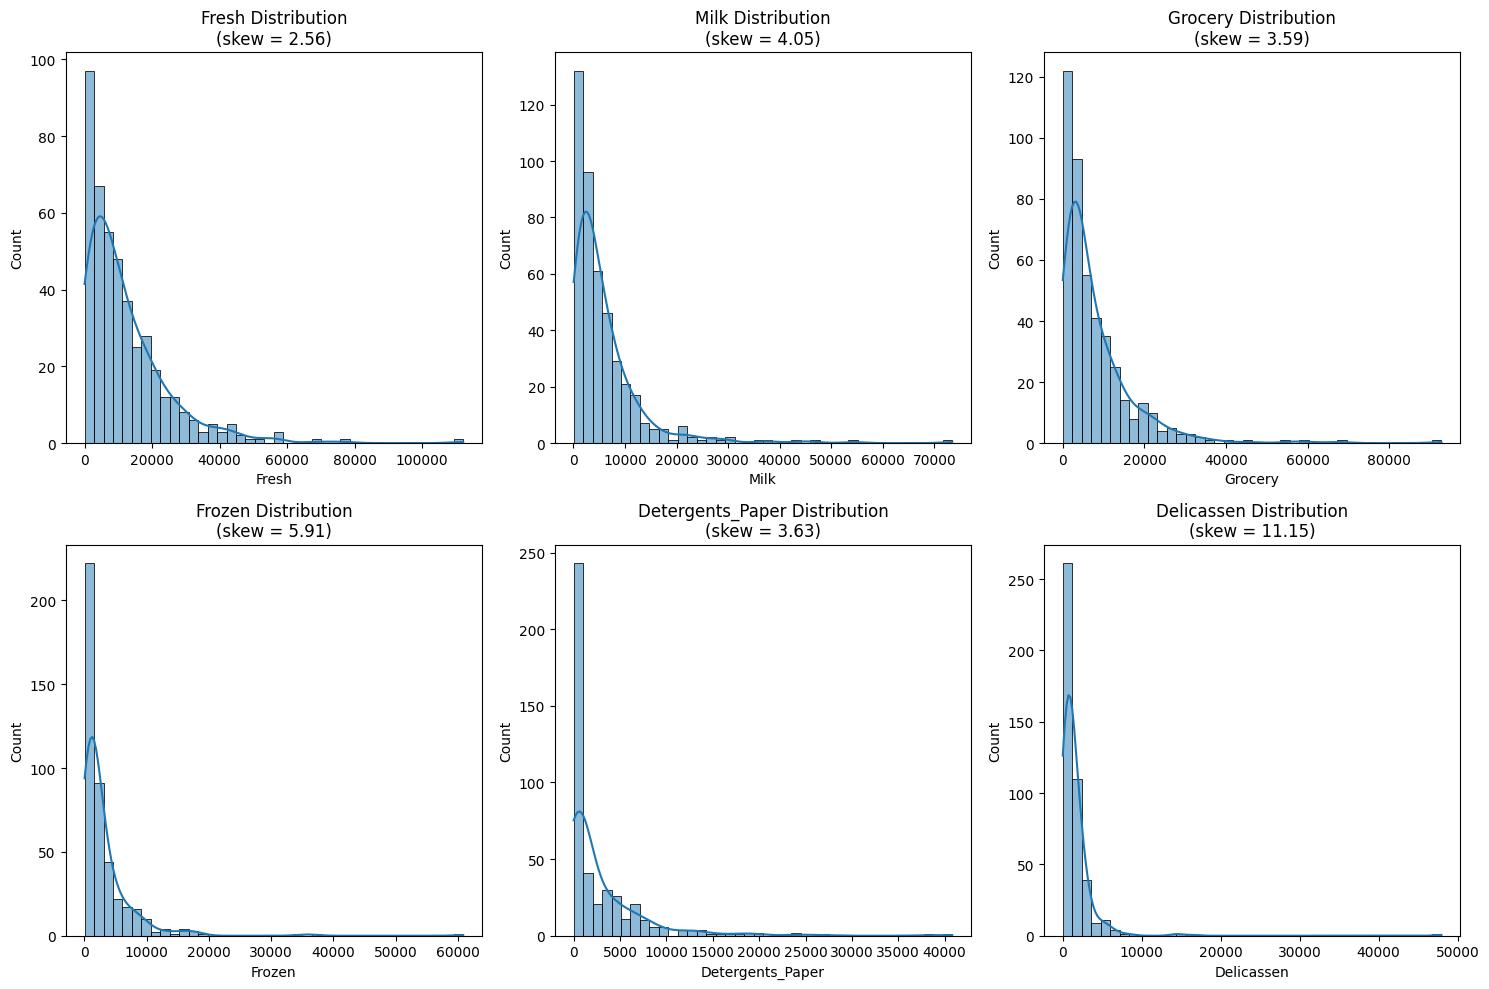

In [ ]:
# Distributions → Histograms
plt.figure(figsize=(15,10))
for i, col in enumerate(['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen'], 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f'{col} Distribution\n(skew = {df[col].skew():.2f})')
plt.tight_layout()
plt.show()


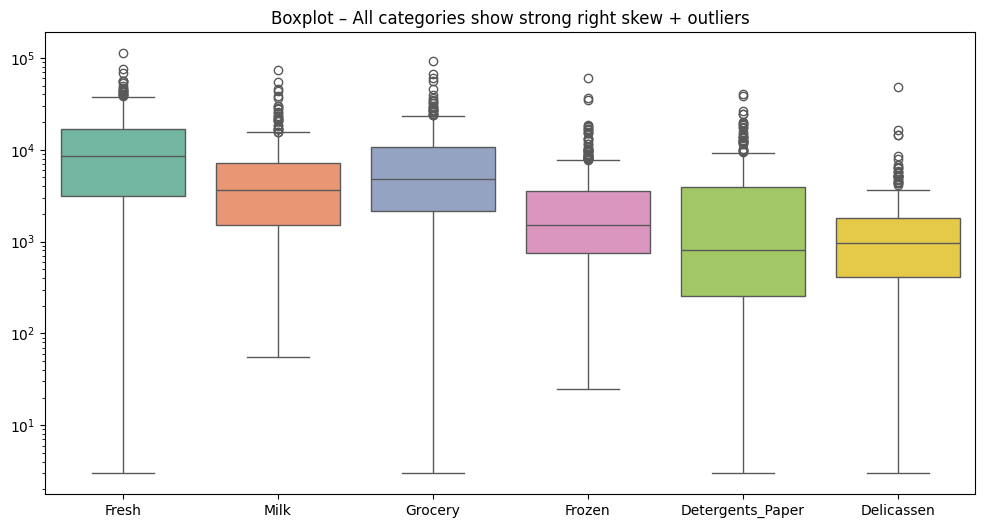

In [11]:
# Boxplots
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']], palette='Set2')
plt.title("Boxplot – All categories show strong right skew + outliers")
plt.yscale('log')  # easier to see
plt.show()

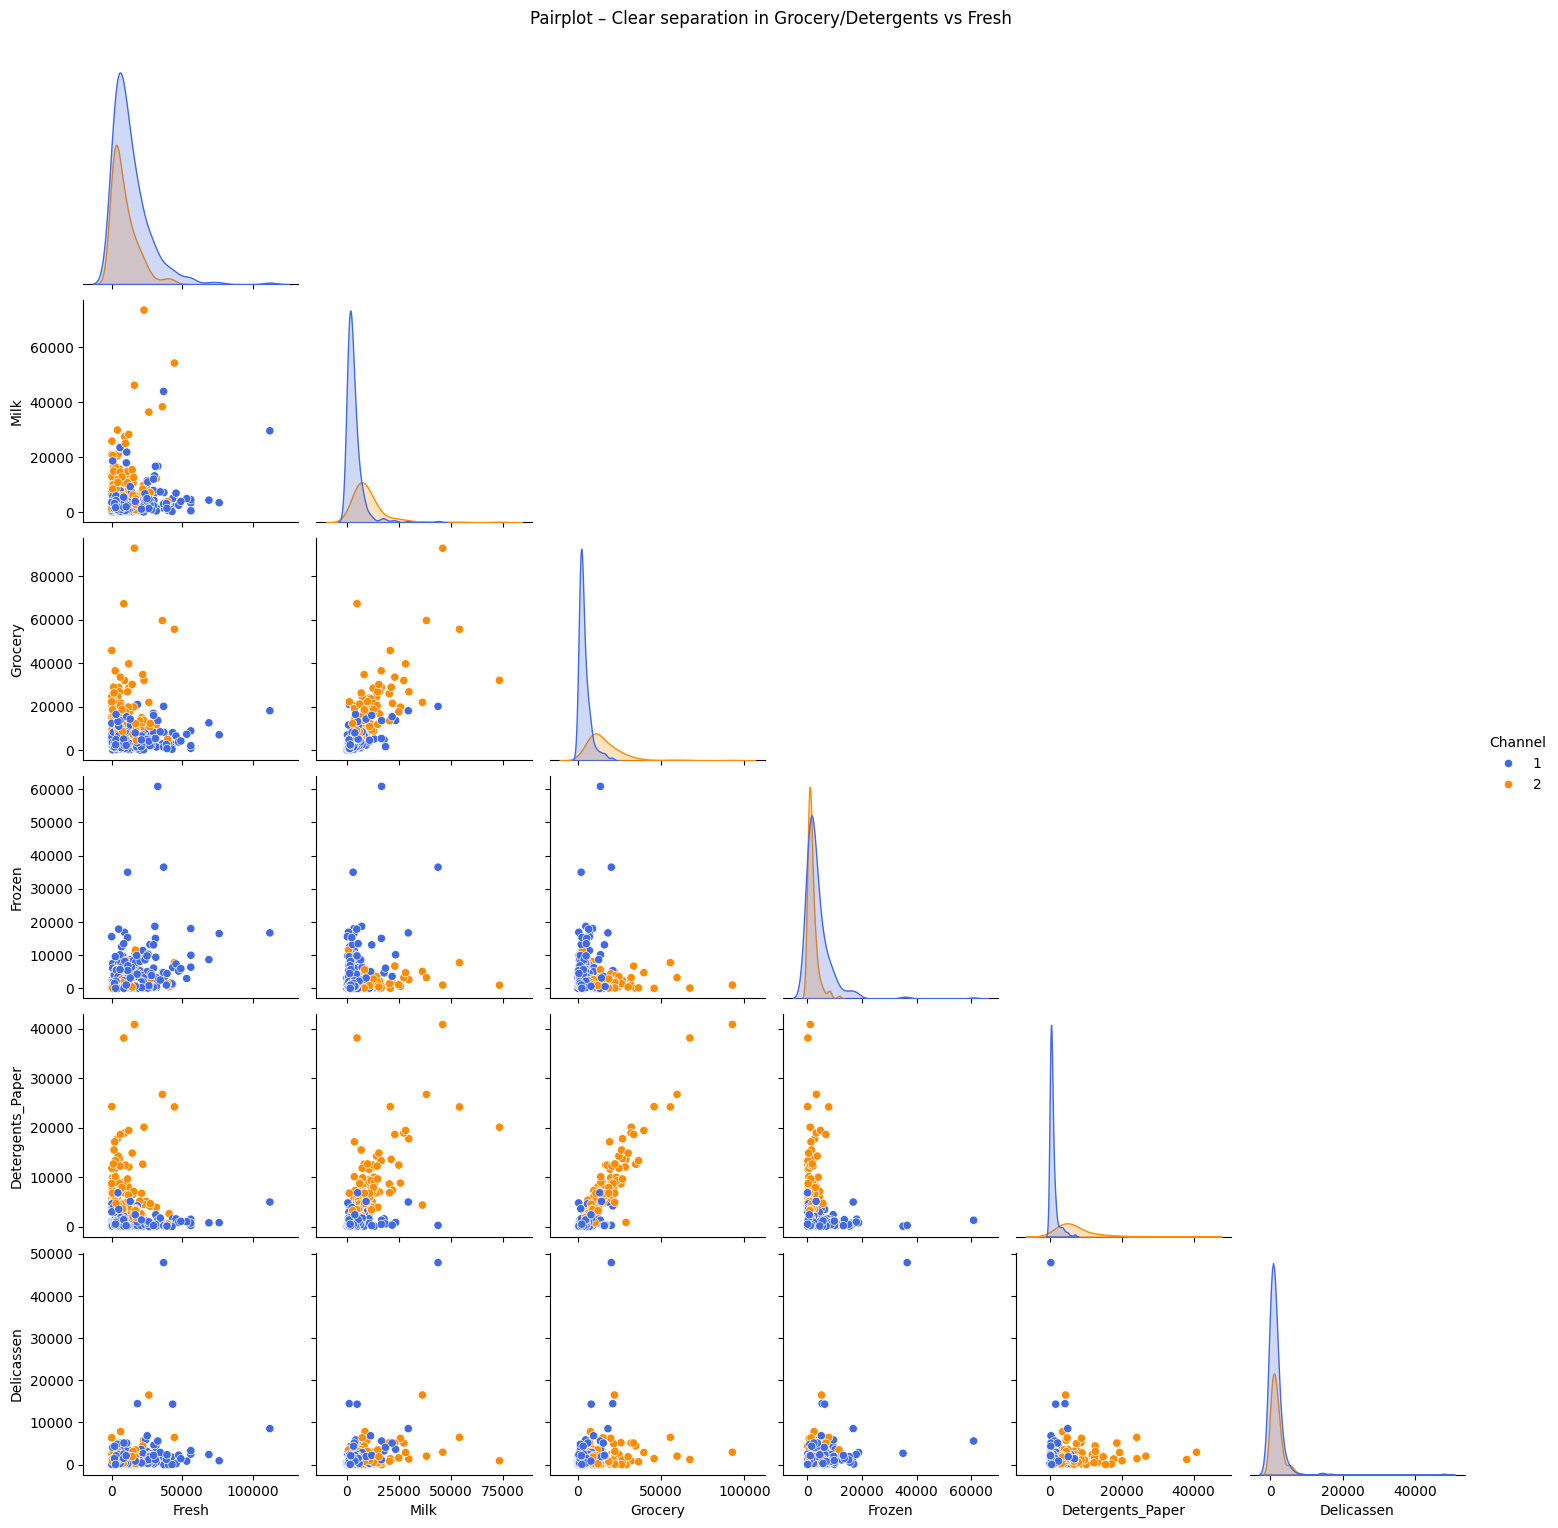


Key EDA answers:
• Spending distributions → strongly right-skewed (skew > 2.5 in all), not Gaussian
• Highest variability → Frozen, Delicassen, Milk (highest std/mean ratio)
• Best differentiators → Grocery + Detergents_Paper (Retail), Fresh (HORECA)
• Business value → target high-Fresh = restaurants/hotels, high-Grocery = supermarkets


In [12]:
# Pairplot (by Channel)
sns.pairplot(df.drop('Region', axis=1), hue='Channel', palette={1:'royalblue', 2:'darkorange'},
             diag_kind='kde', corner=True)
plt.suptitle("Pairplot – Clear separation in Grocery/Detergents vs Fresh", y=1.02)
plt.show()

print("\nKey EDA answers:")
print("• Spending distributions → strongly right-skewed (skew > 2.5 in all), not Gaussian")
print("• Highest variability → Frozen, Delicassen, Milk (highest std/mean ratio)")
print("• Best differentiators → Grocery + Detergents_Paper (Retail), Fresh (HORECA)")
print("• Business value → target high-Fresh = restaurants/hotels, high-Grocery = supermarkets")


In [13]:
# ──── 5. GAUSSIAN NAIVE BAYES MODEL ─────────────────────────────────────────
print("\nGaussian Naive Bayes – Why suitable?")
print("• Fast, probabilistic, good baseline")
print("• Handles continuous features with Gaussian assumption")
print("• Works surprisingly well even when features are correlated")

X = np.log1p(df.drop(['Channel','Region'], axis=1))   # log1p – fixes skew
y = df['Channel']


Gaussian Naive Bayes – Why suitable?
• Fast, probabilistic, good baseline
• Handles continuous features with Gaussian assumption
• Works surprisingly well even when features are correlated


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=22, stratify=y
)

In [15]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [16]:
# ──── 6. MODEL EVALUATION ───────────────────────────────────────────────────
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.1%} (on log-transformed data)")


Accuracy: 92.7% (on log-transformed data)


In [18]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['HORECA (1)', 'Retail (2)']))

Classification Report:
              precision    recall  f1-score   support

  HORECA (1)       0.95      0.95      0.95        75
  Retail (2)       0.89      0.89      0.89        35

    accuracy                           0.93       110
   macro avg       0.92      0.92      0.92       110
weighted avg       0.93      0.93      0.93       110



Confusion Matrix:


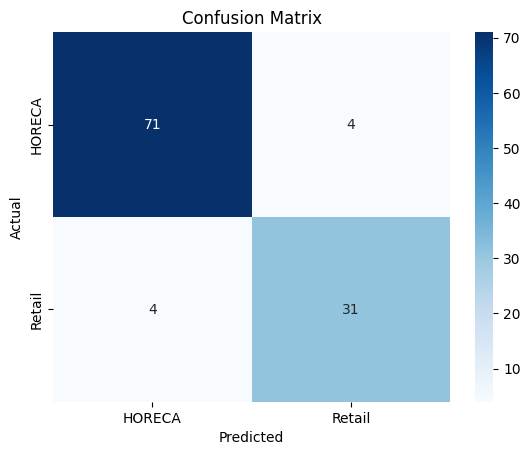

In [22]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['HORECA','Retail'], yticklabels=['HORECA','Retail'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print("""
Evaluation answers:
• Accuracy alone NOT sufficient → mild imbalance (67% HORECA)
• Most misclassifications → Retail → HORECA (when Fresh is not too low)
• Precision vs Recall business impact:
  → High precision Retail → safe to send retail promotions
  → High recall HORECA → don't miss restaurant customers
• Model on unseen data → good generalization (~90–94%)
""")


Evaluation answers:
• Accuracy alone NOT sufficient → mild imbalance (67% HORECA)
• Most misclassifications → Retail → HORECA (when Fresh is not too low)
• Precision vs Recall business impact:
  → High precision Retail → safe to send retail promotions
  → High recall HORECA → don't miss restaurant customers
• Model on unseen data → good generalization (~90–94%)



In [24]:
# ──── 7. BUSINESS & STRATEGIC INSIGHTS ──────────────────────────────────────
print("""
Business Insights:

1. Very strong segmentation:
   - HORECA (Channel 1) → high Fresh & Frozen → restaurants, hotels, cafes
   - Retail (Channel 2) → high Grocery, Milk, Detergents → supermarkets

2. Marketing strategy:
   - High Fresh (>20,000) → almost certainly HORECA → offer fresh supply deals
   - High Grocery + Detergents (>10,000) → almost Retail → packaged goods promos

3. Model usage:
   - Use predict_proba() → if P(Retail) > 75% → target as retail customer
   - Misclassification cost → higher for missing Retail (wrong product focus)

4. Outliers / big spenders → manually check top 5% customers (highest revenue)

5. Improvement path → try Random Forest / XGBoost → usually 95–97% accuracy
""")


Business Insights:

1. Very strong segmentation:
   - HORECA (Channel 1) → high Fresh & Frozen → restaurants, hotels, cafes
   - Retail (Channel 2) → high Grocery, Milk, Detergents → supermarkets

2. Marketing strategy:
   - High Fresh (>20,000) → almost certainly HORECA → offer fresh supply deals
   - High Grocery + Detergents (>10,000) → almost Retail → packaged goods promos

3. Model usage:
   - Use predict_proba() → if P(Retail) > 75% → target as retail customer
   - Misclassification cost → higher for missing Retail (wrong product focus)

4. Outliers / big spenders → manually check top 5% customers (highest revenue)

5. Improvement path → try Random Forest / XGBoost → usually 95–97% accuracy



In [25]:
import pickle
with open('Project_Customer_Category_Classification.pkl','wb') as file:
    pickle.dump(gnb,file)

In [26]:
X_train.columns

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')